<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/flower_fruit/classify_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determine confidence threshold for Flower/Fruit Classification Models 
---
*Last Updated 27 September 2020*   
Choose which trained model and confidence threshold values to use for classifying flowers/fruits from EOL images. Threshold values should be chosen that maximize coverage and minimize error.

After choosing the final model/combination of models to use in [det_conf_threshold.ipynb](https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/flower_fruit/det_conf_threshold.ipynb), run this notebook. 

### Imports
---

In [ ]:
# Mount google drive to import/export files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# For working with data and plotting graphs
import itertools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For image classification and training
import tensorflow as tf

### Run images through model(s) for classification of flowers/fruits
---   
Use model(s) and confidence threshold(s) selected in det_conf_threshold.ipynb

#### Define functions & variables

In [ ]:
import csv

# Load trained model from path
TRAIN_SESS_NUM = "07"
saved_model_path = '/content/drive/My Drive/summer20/classification/flower_fruit/saved_models/' + TRAIN_SESS_NUM
flower_model = tf.keras.models.load_model(saved_model_path)
TRAIN_SESS_NUM = "11"
saved_model_path = '/content/drive/My Drive/summer20/classification/flower_fruit/saved_models/' + TRAIN_SESS_NUM
null_model = tf.keras.models.load_model(saved_model_path)
label_names = ['Flower', 'Fruit', 'Null']

# Load in image from URL
# Modified from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb#scrollTo=JhVecdzJTsKE
def image_from_url(url, fn):
  file = tf.keras.utils.get_file(fn, url) # Filename doesn't matter
  disp_img = tf.keras.preprocessing.image.load_img(file)
  img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = tf.keras.applications.mobilenet_v2.preprocess_input(
    x[tf.newaxis,...])
  return x, disp_img

# Read in EOL image bundle dataframe
# TO DO: Type in image bundle address using form field to right
bundle = 'https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_000031.txt' #@param {type:"string"}
df = pd.read_csv(bundle, sep='\t', header=0)
df.head()

#### Run 20K image bundle through classification pipeline

In [ ]:
# Write header row of output crops file
# TO DO: Change file name for each bundle/run abcd if doing 4 batches using dropdown form to right
tags_file = "angiosperm_tags_flowfru_20k_d" #@param ["angiosperm_tags_flowfru_20k_a", "angiosperm_tags_flowfru_20k_b", "angiosperm_tags_flowfru_20k_c", "angiosperm_tags_flowfru_20k_d"]
tags_fpath = "/content/drive/My Drive/summer20/classification/flower_fruit/results/" + tags_file + ".tsv"
with open(tags_fpath, 'a') as out_file:
                  tsv_writer = csv.writer(out_file, delimiter='\t')
                  tsv_writer.writerow(["eolMediaURL", "identifier", \
                                       "dataObjectVersionID", "ancestry", \
                                       "tag7", "tag7_conf", "tag11", "tag11_conf"])

In [ ]:
# Set number of seconds to timeout if image url taking too long to open
import socket
socket.setdefaulttimeout(10)
import time

# TO DO: Set start and end rows to run inference for from EOL image bundle using form field to right
# If running in 4 batches of 5000 images, use values in dropdown menu
start = 15000 #@param ["0", "5000", "10000", "15000"] {type:"raw"}
end = 20000 #@param ["5000", "10000", "15000", "20000"] {type:"raw"}

# Loop through EOL image bundle to classify images and generate tags
for i, row in df.iloc[start:end].iterrows():
  try:
    # Get url from image bundle
    url = df['eolMediaURL'][i]
    # Read in image from url
    fn = str(i) + '.jpg'
    img, disp_img = image_from_url(url, fn)
    # Record inference time
    start_time = time.time()
    # Detection and draw boxes on image
    # For flowers/fruits (reproductive structures)
    predictions = flower_model.predict(img, batch_size=1)
    label_num = np.argmax(predictions)
    f_conf = predictions[0][label_num]
    f_class = label_names[label_num]
    # For null (no reproductive structures)
    predictions = null_model.predict(img, batch_size=1)
    label_num = np.argmax(predictions)
    n_conf = predictions[0][label_num]
    n_class = label_names[label_num]
    end_time = time.time()
    # Display progress message after each image
    print('Inference complete for {} of {} images'.format(i, (end-start)))

    # Optional: Show classification results for images
    # Only use to view predictions on <50 images at a time
    #_, ax = plt.subplots(figsize=(10, 10))
    #ax.imshow(disp_img)
    #plt.axis('off')
    #plt.title("{}) Mod 7 Prediction: {}, Confidence: {}%, \
    #\n  Mod 11 Prediction: {}, Confidence: {}%, Inference Time: {}".format(i, \
    #f_class, f_conf, n_class, n_conf,format(end_time-start_time, '.3f')))

    # Export tagging results to tsv
    # Define variables for export
    identifier = df['identifier'][i]
    dataObjectVersionID = df['dataObjectVersionID'][i]
    ancestry = df['ancestry'][i]
    with open(tags_fpath, 'a') as out_file:
        tsv_writer = csv.writer(out_file, delimiter='\t')
        tsv_writer.writerow([url, identifier, dataObjectVersionID, ancestry, \
                               f_class, f_conf, n_class, n_conf])

  except:
    print('Check if URL from {} is valid'.format(url))

#### Post-process classification predictions using confidence threshold values for models 7 and 11 chosen in det_conf_threshold.ipynb

In [ ]:
# Combine exported model predictions and confidence values from above to one dataframe
base = '/content/drive/My Drive/summer20/classification/flower_fruit/results/angiosperm_tags_flowfru_20k_' 
exts = ['a.tsv', 'b.tsv', 'c.tsv', 'd.tsv']
all_filenames = [base + e for e in exts]
df = pd.concat([pd.read_csv(f, sep='\t', header=0, na_filter = False) for f in all_filenames], ignore_index=True)

# Filter predictions using determined confidence value thresholds
# Make column for "reproductive structures present?" tag
df['reprod'] = np.nan
for i, row in df.iterrows():
  # If Model 7 predicts flower with >1.6 confidence
  if df['tag7'][i]=="Flower" and df['tag7_conf'][i]>1.6: 
    # And Model 11 does not predict null with >= 1.5 confidence
    if df['tag11'][i]=="Null" and df['tag11_conf'][i]>=1.5:
      # Reproductive structures present -> YES
      df['reprod'][i] = "Y"
    # And Model 11 predicts null with >= 1.5 confidence
    elif df['tag11'][i]=="Null" and df['tag11_conf'][i]<1.5: 
      # Reproductive structures present -> NO
      df['reprod'][i] = "N"
    # And Model 11 predicts fruit or flower with any confidence
    else:
      # Reproductive structures present -> NO
      df['reprod'][i] = "Y"

  # If Model 7 predicts flower with <= 1.6 confidence
  elif df['tag7'][i]=="Flower" and df['tag7_conf'][i]<=1.6:
      # Reproductive structures present -> Maybe
      df['reprod'][i] = "M"

  # If Model 7 predicts fruit or null with any confidence
  else:
      # Reproductive structures present -> NO
      df['reprod'][i] = "N"

# Write results to tsv
df.to_csv("/content/drive/My Drive/summer20/classification/flower_fruit/results/angiosperm_tags_flowfru_20k_finaltags.tsv", sep='\t', index=False)

In [ ]:
# Inspect results
print(df.head(10))
print("Number of positive identified reproductive structures: {}".format(len(df[df['reprod']=="Y"])))
print("Number of possible identified reproductive structures: {}".format(len(df[df['reprod']=="M"])))
print("Number of negative identified reproductive structures: {}".format(len(df[df['reprod']=="N"])))

1572864/1569661 [==============================] - 1s 1us/step
Successfully loaded 3001 of 50 images
1581056/1574191 [==============================] - 1s 1us/step
Successfully loaded 3002 of 50 images
1294336/1294325 [==============================] - 1s 1us/step
Successfully loaded 3003 of 50 images
1622016/1614383 [==============================] - 1s 1us/step
Successfully loaded 3004 of 50 images
1679360/1675072 [==============================] - 1s 1us/step
Successfully loaded 3005 of 50 images
10444800/10437089 [==============================] - 2s 0us/step
Successfully loaded 3006 of 50 images
1130496/1127956 [==============================] - 1s 1us/step
Successfully loaded 3007 of 50 images
12247040/12245946 [==============================] - 2s 0us/step
Successfully loaded 3008 of 50 images
12337152/12329478 [==============================] - 2s 0us/step
Successfully loaded 3009 of 50 images
2523136/2516663 [==============================] - 1s 0us/step
Successfully loaded 30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1679360/1676217 [==============================] - 1s 1us/step
Successfully loaded 3022 of 50 images
2170880/2167541 [==============================] - 1s 1us/step
Successfully loaded 3023 of 50 images
1531904/1530762 [==============================] - 1s 1us/step
Successfully loaded 3024 of 50 images
1875968/1874635 [==============================] - 1s 1us/step
Successfully loaded 3025 of 50 images
7938048/7935441 [==============================] - 1s 0us/step
Successfully loaded 3026 of 50 images
1171456/1169350 [==============================] - 1s 1us/step
Successfully loaded 3027 of 50 images
9502720/9497814 [==============================] - 1s 0us/step
Successfully loaded 3028 of 50 images
9453568/9446950 [==============================] - 1s 0us/step
Successfully loaded 3029 of 50 images
9601024/9592969 [==============================] - 2s 0us/step
Successfully loaded 3030 of 50 images
6324224/6316630 [==============================] - 1s 0us/step
Successfully loaded 3031 of 

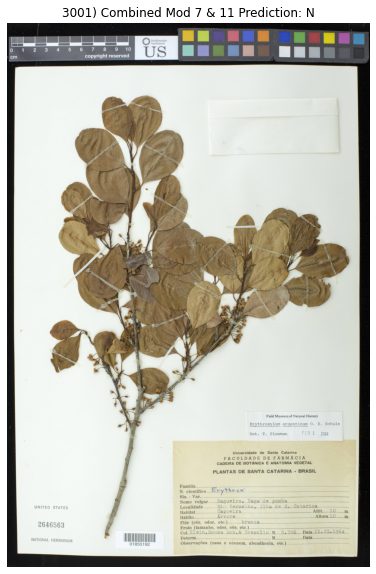

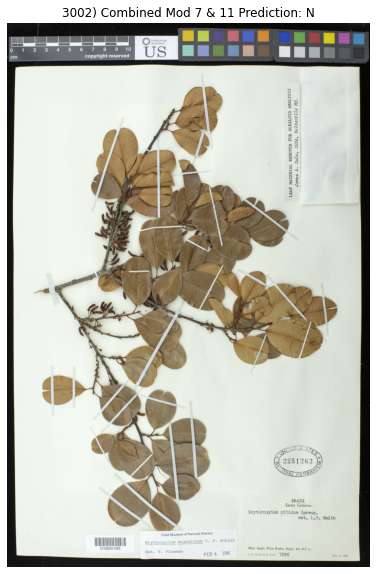

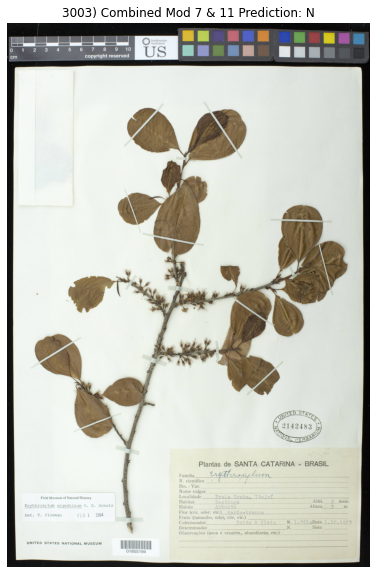

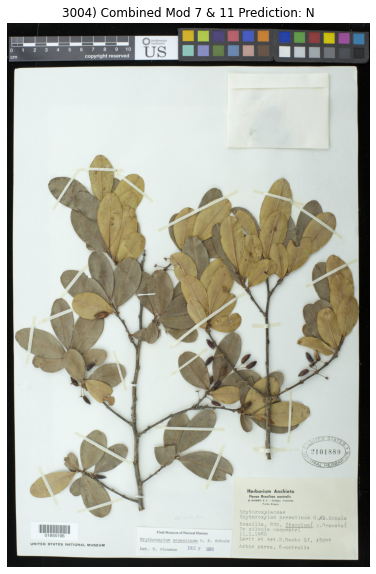

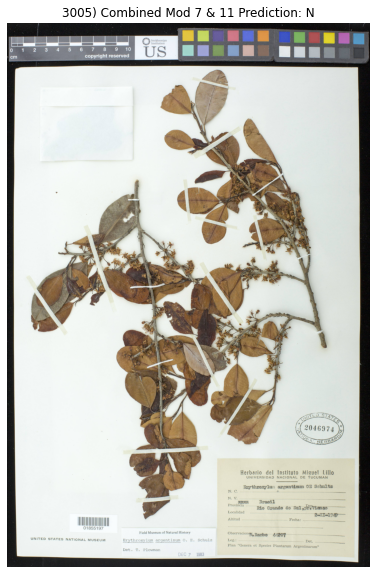

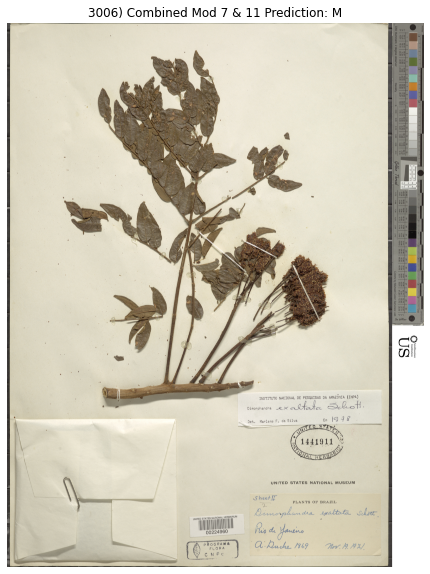

In [ ]:
# Set number of seconds to timeout if image url taking too long to open
import socket
socket.setdefaulttimeout(10)

# Function to load in image from URL
# Modified from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb#scrollTo=JhVecdzJTsKE
def image_from_url(url, fn):
  file = tf.keras.utils.get_file(fn, url) # Filename doesn't matter
  disp_img = tf.keras.preprocessing.image.load_img(file)
  img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = tf.keras.applications.mobilenet_v2.preprocess_input(
    x[tf.newaxis,...])
  return x, disp_img

# TO DO: Set start and end rows to run inference for from EOL image bundle using form field to right
# If running in 4 batches of 5000 images, use values in dropdown menu
start =  3000#@param {type:"raw"}
end = 3050 #@param {type:"raw"}

# Loop through EOL image bundle to classify images and generate tags
for i, row in df.iloc[start:end].iterrows():
  try:
    # Get url from image bundle
    url = df['eolMediaURL'][i]
    # Read in image from url
    fn = str(i) + '.jpg'
    img, disp_img = image_from_url(url, fn)
    # Record inference time
    pred = df['reprod'][i]
    # Display progress message after each image is loaded
    print('Successfully loaded {} of {} images'.format(i+1, (end-start)))

    # Show classification results for images
    # Only use to view predictions on <50 images at a time
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(disp_img)
    plt.axis('off')
    plt.title("{}) Combined Mod 7 & 11 Prediction: {}".format(i+1, pred))

  except:
    print('Check if URL from {} is valid'.format(url))